In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
os.getcwd()
os.chdir('drive/MyDrive/NLP/Dacon_NH competition/')

In [3]:
import pandas as pd

train = pd.read_csv('data/news_train_preprocessing_Mecab(all_alphabet).csv')
train.head()

,n_id,date,title,content,ord,info,new_article,text
0,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,[이데일리 MARKETPOINT]15:32 현재 코스닥 기관 678억 순매도,1,0,"['이데일리', 'MARKETPOINT', '현재', '코스닥', '기관', '억'...",이데일리 MARKETPOINT 현재 코스닥 기관 억 순매도
1,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"""실적기반"" 저가에 매집해야 할 8월 급등유망주 TOP 5 전격공개",2,1,"['실적', '기반', '저가', '에', '매집', '해야', '할', '월', ...",실적 기반 저가 에 매집 해야 할 월 급등 유망주 TOP 전격 공개
2,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"하이스탁론, 선취수수료 없는 월 0.4% 최저금리 상품 출시",3,1,"['하이스', '탁론', '선취', '수수료', '없', '는', '월', '최저'...",하이스 탁론 선취 수수료 없 는 월 최저 금리 상품 출시
3,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,종합 경제정보 미디어 이데일리 - 무단전재 & 재배포 금지,4,0,"['종합', '경제', '정보', '미디어', '이데일리', '무단', '전재', ...",종합 경제 정보 미디어 이데일리 무단 전재 재 배포 금지
4,NEWS09727,20200626,"롯데·공영 등 7개 TV 홈쇼핑들, 동행세일 동참",전국적인 소비 붐 조성에 기여할 예정,1,0,"['전국', '적', '인', '소비', '붐', '조성', '에', '기여', '...",전국 적 인 소비 붐 조성 에 기여 할 예정


In [4]:
null_index = train[train['text'].isna()].index

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118745 entries, 0 to 118744
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   n_id         118745 non-null  object
 1   date         118745 non-null  int64 
 2   title        118745 non-null  object
 3   content      118745 non-null  object
 4   ord          118745 non-null  int64 
 5   info         118745 non-null  int64 
 6   new_article  118745 non-null  object
 7   text         118665 non-null  object
dtypes: int64(3), object(5)
memory usage: 7.2+ MB


In [6]:
train = train.fillna('')

In [7]:
train.iloc[null_index, 5].value_counts()    # text가 NaN값인 행의 'info' 정보 살펴보기

0    79
1     1
Name: info, dtype: int64

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

token_list = [t.split(' ') for t in train['text']]

def text2sequence(train_text, max_len=100):   # 여기 max_len에 가장 긴 문장의 길이를 넣기
  tokenizer = Tokenizer()                                   # keras의 vectorizing 함수 호출
  tokenizer.fit_on_texts(train_text)                        # train 문장에 fit
  train_X_seq = tokenizer.texts_to_sequences(train_text)    # 각 토큰들에 정수값 부여
  vocabulary = tokenizer.word_index
  vocab_size = len(tokenizer.word_index) + 1                # 모델에 알려줄 vocabulary의 크기 계산(padding값 0을 포함해야 하므로 +1)
  print('vocab_size : ', vocab_size)
  X_train = pad_sequences(train_X_seq, maxlen = max_len)    # 설정한 문장의 최대 길이만큼 padding

  return X_train, vocabulary, vocab_size, tokenizer

train_y = train['info']
train_X, vocabulary, vocab_size, vectorizer = text2sequence(token_list, max_len = 100)
print(train_X.shape, train_y.shape) 

vocab_size :  41725
(118745, 100) (118745,)


In [16]:
import numpy as np
import gensim

word2vec = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary = True)
embedding_matrix = np.zeros((vocab_size, 300))     # 300차원의 임베딩 매트릭스 생성
cnt = 0

for index, word in enumerate(vocabulary):          # vocabulary에 있는 토큰들을 하나씩 넘김
  if word in word2vec:                             # 넘겨받은 토큰이 word2vec에 존재하면(이미 훈련이 된 토큰이라는 의미)
    embedding_vector = word2vec[word]              # 해당 토큰에 해당하는 vector를 불러오고
    embedding_matrix[index] = embedding_vector     # 해당 위치의 embedding_matrix에 저장
  else:
    cnt += 1
    # print("word2vec에 없는 단어입니다.")
    continue

In [17]:
print(cnt)

38906


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dropout, Dense
from tensorflow.keras import regularizers

max_len = 100

model = Sequential()
model.add(Embedding(vocab_size, 300, weights = [embedding_matrix], input_length = max_len))  # 임베딩 가중치 적용 코드
model.add(SpatialDropout1D(0.3))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer = regularizers.l2(0.001)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
print(model.summary())

history = model.fit(train_X, train_y, epochs=5, batch_size=64, validation_split=0.2)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 300)          12517200  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 100, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 12,614,865
Trainable params: 12,614,865
Non-trainable params: 0
__________________________________________

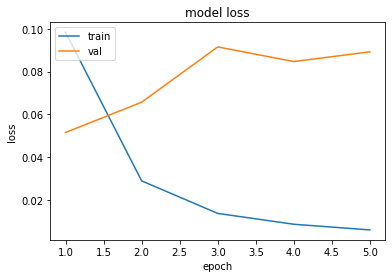

In [25]:
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [69]:
test = pd.read_csv('data/news_test_preprocessing_Mecab(all_alphabet).csv')
test.head()

,n_id,date,title,content,ord,id,new_article,text
0,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",마이크로 LED TV 장비 양산 돌입- 전방업체 투자 확대로 본업도 호조연일 '신고가',1,NEWS00237_1,"['마이크로LED', 'TV', '장비', '양산', '돌입', '전방', '업체'...",마이크로LED TV 장비 양산 돌입 전방 업체 투자 확대 로 본업 도 호조 연일 신고 가
1,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",[이데일리 김대웅 기자] 반도체 장비 업체 코세스(089890)의 기술력이 마이크로...,2,NEWS00237_2,"['이데일리', '김대웅', '기자', '반도체장비', '업체', '코', '세스'...",이데일리 김대웅 기자 반도체장비 업체 코 세스 의 기술력 이 마이크로 발광다이오드 ...
2,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",최근 대형 업체들과 거래를 맺고 관련 장비들의 양산에 돌입하면서 주가도 연일 신고가...,3,NEWS00237_3,"['최근', '대형업체', '들', '과', '거래', '를', '맺', '고', ...",최근 대형업체 들 과 거래 를 맺 고 관련 장비 들 의 양산 에 돌입 하 면서 주가...
3,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",TV를 필두로 올해부터 마이크로 LED의 시대가 본격적으로 개화할 것으로 예상되면서...,4,NEWS00237_4,"['TV', '를', '필두', '로', '올해', '부터', '마이크로LED', ...",TV 를 필두 로 올해 부터 마이크로LED 의 시대 가 본격 적 으로 개 화 할 것...
4,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대","코세스는 반도체 장비를 제조, 판매하는 업체로 지난 2006년 11월 코스닥 시장에...",5,NEWS00237_5,"['코', '세스', '는', '반도체장비', '를', '제조', '판매', '하'...",코 세스 는 반도체장비 를 제조 판매 하 는 업체 로 지난 년 월 코스닥 시장 에 ...


In [72]:
null_index_test = test[test['text'].isna()].index

In [57]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142565 entries, 0 to 142564
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   n_id         142565 non-null  object
 1   date         142565 non-null  int64 
 2   title        142565 non-null  object
 3   content      142565 non-null  object
 4   ord          142565 non-null  int64 
 5   id           142565 non-null  object
 6   new_article  142565 non-null  object
 7   text         142467 non-null  object
dtypes: int64(2), object(6)
memory usage: 8.7+ MB


In [60]:
test = test.fillna('')

In [64]:
token_list_test = [t.split(' ') for t in test['text']]

test_X_seq = vectorizer.texts_to_sequences(token_list_test)    # 각 토큰들에 정수값 부여
X_test = pad_sequences(test_X_seq, maxlen = max_len)           # 설정한 문장의 최대 길이만큼 padding

print(X_test.shape) 

(142565, 100)


In [65]:
submission_data = pd.read_csv('data/sample_submission.csv')

pred_test = model.predict(X_test)
submission_data.loc[:,'info'] = np.where(pred_test > 0.5, 1,0).reshape(-1)

In [74]:
submission_data.iloc[null_index_test, -1].value_counts()

0    98
Name: info, dtype: int64

In [67]:
submission_data.to_csv("submission_data_chan.csv", index = False)
submission_data

,id,info
0,NEWS00237_1,1
1,NEWS00237_2,0
2,NEWS00237_3,0
3,NEWS00237_4,0
4,NEWS00237_5,0
...,...,...
142560,NEWS09482_72,1
142561,NEWS09482_73,1
142562,NEWS09482_74,1
142563,NEWS09482_75,1
